https://colab.research.google.com/github/CS7150/CS7150-Homework-4/blob/main/HW4_Transformers.ipynb

# Homework 4: Transformers

Transformers were originally developed by [Vaswani 2017](https://papers.baulab.info/Vaswani-2017.pdf) for solving the problem of natural language translation.  The idea is to allow information to flow through a network through learned connections called "attention heads" that learn to locate relevant connections by finding matching content between a querying node and potential key nodes.

An excellent visual overview of transformers is given by Jay Alamar's blog here:
[Illustrated Transformer](https://jalammar.github.io/illustrated-transformer/)

It is also worth reading his blog explanations of transformer derivatives including BERT and GPT:
[Illustrated BERT](https://jalammar.github.io/illustrated-bert/)
[Illustrated GPT2](https://jalammar.github.io/illustrated-gpt2/)

In this notebook, you will build all the key components of a transformer model; and we provide some training data and a training routine to train it on natural language translation.

Collaborated with Sai Vineeth Kaza for this Assignment
Referred : https://github.com/mikkkeldp/seq2seq_transformer_translation
https://github.com/aladdinpersson/Machine-Learning-Collection/blob/088bdb63e9ccba93da9f14289cb4e66f67539afb/ML/Pytorch/more_advanced/transformer_from_scratch/transformer_from_scratch.py#L1

## Package Setup
First, let's install some packages that you would require for this assignment.

In [ ]:
!pip install torchdata
!pip install seaborn
!pip install -U spacy
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm
## Updating torchtext version
!pip install -U torchtext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.5 MB 37.1 MB/s 
     |██████████████▌                 | 402.8 MB 11.5 MB/s eta 0:00:43
ERROR: Operation cancelled by user
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 29.1 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 14.6 MB 3.1 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')
Looking in indexes: h

In [ ]:
import torch
import math
import random
import string
import sys
import numpy as np
from random import choices
from collections import defaultdict
from torch import nn, Tensor, optim
import torch.nn.functional as F
from torch.utils.data import dataset
from typing import Tuple
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Google Colab Setup

Next we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.

In [ ]:
in_colab = False
try:
    from google.colab import drive
    drive.mount('/content/drive')
    in_colab = True
except:
    pass

Mounted at /content/drive


In [ ]:
import os
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = None
if in_colab:
    # TODO: Fill in the Google Drive path where you uploaded the assignment
    # Example: If you create a CS7150 folder and put all the files under HW4 folder, then 'CS7150/HW4'
    # GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'CS7150/HW4'
    GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks'
    GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
    print(os.listdir(GOOGLE_DRIVE_PATH))

['HW4_Transformers.ipynb', 'HW2.2_DenoisingAutoencoder.ipynb', 'Untitled', 'HW2_2_DenoisingAutoencoder.ipynb', 'HW2_0_Backpropagation.ipynb', 'Copy of HW3.1-Classifiers.ipynb', 'Copy of HW3.2-Generative_DAE.ipynb', 'Copy of HW3.3-Visualization_Examples.ipynb', 'HW3_1_Classifiers.ipynb', 'HW3_2_Generative_DAE.ipynb', 'HW3_3_Visualization_Examples.ipynb', 'abh_CS6120_NLP_Assignment_2_F22.ipynb', 'Rajesh NLP assign 2.ipynb', 'CS6120_NLP_Assignment_2_F22 (1) (1).ipynb', 'Untitled0.ipynb', 'Copy of by-hand-1d-convolution.ipynb', 'HW2_1_QuickDrawClassifier.ipynb', ' raj_vineeth.ipynb']


# Machine Translation with Transformer

### Task 1.1: Implement the multi-head attention module (no for loops allowed)

#### Exercise 1.1.1: Complete the `compute_attn_scores` function, which is a helper function for the multi-head attention module that you will implement later.

In [ ]:
def compute_attn_scores(K, Q, mask=None):
    '''
    The purpose of this function is to compute the attention score using the
    given K and Q vectors.
      - K has the shape [batch_size, num_heads, num_K_tokens, dim_per_head]
      - Q has the shape [batch_size, num_heads, num_Q_tokens, dim_per_head]
      - mask has shape [batch_size, num_heads, num_Q_tokens, num_K_tokens]
    Returns:
      - Score of shape [batch_size, num_heads, num_Q_tokens, num_K_tokens]
        where summing all the K scores for each Q adds up to 1 
        and where attention is near 0 wherever the mask is 0.
            
    '''

    ###########################################################################
    # TODO: Compute the scores based on dot product between transformed query,#
    # key, and value. You may find torch.matmul helpful, whose documentation  #
    # can be found at                                                         #
    # https://pytorch.org/docs/stable/generated/torch.matmul.html.            # 
    # Alternatively, you can consider torch.einsum, whose documentation       #
    # can be found at                                                         #
    # https://pytorch.org/docs/stable/generated/torch.einsum                  # 
    #                                                                         #
    # Since no for loops are allowed here,                                    #
    # you are allowed to use tensor transpose, permute or view to achieve     #
    # the required shapes.                                                    #
    ###########################################################################

    dot_prod_scores = torch.matmul(Q, K.transpose(-2, -1))
    # print(Q.shape)
    # print(K.shape)

    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################

    # We divide the dot product similarity scores by square root of the channel
    # dimension per head.

    scaled_dot_prod_scores = dot_prod_scores/ math.sqrt(K.shape[3])
    
    if mask is not None:
        # We simply set the similarity scores to be near zero for the positions
        # where the attention should not be done. Think of why we do this.
        scaled_dot_prod_scores = scaled_dot_prod_scores.masked_fill(mask == 0, -1e9)
    
    ###########################################################################
    # TODO: Compute the attention scores, which are then used to modulate the #
    # value tensor.                                                           #
    ###########################################################################

    attn_scores = F.softmax(scaled_dot_prod_scores, dim=-1)
    # print(attn_scores.shape)

    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return attn_scores

Make sure to pass the following tests after implementing the above function.

In [ ]:
# Single-headed test
K = torch.tensor([[[
    [1.0,0.0],
    [1.0,0.0],
    [1.0,0.0],
    [0.0,1.0],
    [0.0,1.0]
    ]]])
Q = torch.tensor([[[
    [1,0],
    [0.5,0.5],
    [0,1]
    ]]])
expected_attn_scores = torch.tensor([[[
    # Heatmap for the single head
    [0.2509, 0.2509, 0.2509, 0.1237, 0.1237], # results for query 0
    [0.2000, 0.2000, 0.2000, 0.2000, 0.2000], # results for query 1
    [0.1417, 0.1417, 0.1417, 0.2874, 0.2874]  # results for query 2
    ]]])

actual_attn_scores = compute_attn_scores(K,Q)

print("Actual attn scores:\n", actual_attn_scores)
assert (actual_attn_scores - expected_attn_scores).abs().max() <= 1e-4


Actual attn scores:
 tensor([[[[0.2509, 0.2509, 0.2509, 0.1237, 0.1237],
          [0.2000, 0.2000, 0.2000, 0.2000, 0.2000],
          [0.1417, 0.1417, 0.1417, 0.2874, 0.2874]]]])


In [ ]:
# Multi-headed test
K = torch.tensor([[[
    [1.0,0.0],
    [0.0,1.0],
    [1.0,0.0],
    [0.0,1.0],
    [1.0,0.0]
    ], [
    [1.0,0.0],
    [1.0,0.0],
    [1.0,0.0],
    [0.0,1.0],
    [0.0,1.0]
    ]]])
Q = torch.tensor([[[
    [1,0],
    [0.5,0.5],
    [0,1]
    ],[
    [0.0,0.0],
    [1.0,0.0],
    [0.0,1.0]
    ]]])
expected_attn_scores =  torch.tensor([[[
    # Heatmap for Head 0
    [0.2509, 0.1237, 0.2509, 0.1237, 0.2509],
    [0.2000, 0.2000, 0.2000, 0.2000, 0.2000],
    [0.1417, 0.2874, 0.1417, 0.2874, 0.1417]],

    # Heatmap for Head 1
    [[0.2000, 0.2000, 0.2000, 0.2000, 0.2000],
    [0.2509, 0.2509, 0.2509, 0.1237, 0.1237],
    [0.1417, 0.1417, 0.1417, 0.2874, 0.2874]]]])

actual_attn_scores = compute_attn_scores(K,Q)

print("Actual attn scores:\n", actual_attn_scores)
assert (actual_attn_scores - expected_attn_scores).abs().max() <= 1e-4

Actual attn scores:
 tensor([[[[0.2509, 0.1237, 0.2509, 0.1237, 0.2509],
          [0.2000, 0.2000, 0.2000, 0.2000, 0.2000],
          [0.1417, 0.2874, 0.1417, 0.2874, 0.1417]],

         [[0.2000, 0.2000, 0.2000, 0.2000, 0.2000],
          [0.2509, 0.2509, 0.2509, 0.1237, 0.1237],
          [0.1417, 0.1417, 0.1417, 0.2874, 0.2874]]]])


In [ ]:
class MultiHeadAttention(nn.Module):
    """
    A module that computes multi-head attention given query, key, and value tensors.
    """
    def __init__(self, input_dim: int, num_heads: int):
        """
        Constructor.
        
        Inputs:
        - input_dim: Dimension of the input query, key, and value. Here we assume they all have
          the same dimensions. But they could have different dimensions in other problems.
        - num_heads: Number of attention heads
        """
        super(MultiHeadAttention, self).__init__()
        
        assert input_dim % num_heads == 0
        
        self.input_dim = input_dim
        self.num_heads = num_heads
        self.dim_per_head = input_dim // num_heads
        
        # We define the linear transformation layers for key, value, and query.
        # We also define the output layer.
        # Think about why input_dim is num_heads * dim_per_head
        # K, Q, V
        self.wk = nn.Linear(input_dim, input_dim)
        self.wq = nn.Linear(input_dim, input_dim)
        self.wv = nn.Linear(input_dim, input_dim)
        
        # output layer
        self.out_layer = nn.Linear(input_dim, input_dim)
        
        
    def forward(self, query: torch.Tensor, key: torch.Tensor, value: torch.Tensor, mask: torch.Tensor=None):
        """
        Compute the attended feature representations.
        
        Inputs:
        - query: Tensor of the shape BxLxC, where B is the batch size, L is the sequence length,
          and C is the channel dimension
        - key: Tensor of the shape BxLxC
        - value: Tensor of the shape BxLxC
        - mask: Tensor indicating where the attention should *not* be performed
        """
        b_q = query.shape[0]
        l_q = query.shape[1]        
        b_k = key.shape[0]
        l_k = key.shape[1]
        scaled_dot_prod_scores = None

        K_all = self.wk(key)
        Q_all = self.wq(query)
        V_all = self.wv(value)

        out = None
        ###########################################################################
        # TODO: Make K, Q, and V all have the following shapes:                   #
        # - K has the shape [batch_size, num_heads, num_K_tokens, dim_per_head]   #
        # - Q has the shape [batch_size, num_heads, num_Q_tokens, dim_per_head]   #
        # - V has the shape [batch_size, num_heads, num_K_tokens, dim_per_head]   #
        #                                                                         #
        # Since no for loops are allowed here,                                    #
        # think of how to use tensor view and transpose or permute to achieve     #
        # the required shapes in a few steps.                                     #
        ###########################################################################
        
        # create K, Q, V
        K = K_all.reshape(b_k, l_k, self.num_heads, self.dim_per_head)
        K = K.permute(0, 2, 1, 3)
        Q = Q_all.reshape(b_q, l_q, self.num_heads, self.dim_per_head)
        Q = Q.permute(0, 2, 1, 3)
        V = V_all.reshape(b_k, l_k, self.num_heads, self.dim_per_head)
        V = V.permute(0, 2, 1, 3)

        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

        # compute attention scores
        attn_scores = compute_attn_scores(K, Q, mask)
        # print(K.shape)
        # print("--------")
        # print(Q.shape)
        # print("----------------")
        # print(attn_scores.shape)
        # print("------------")
        # print(V.shape)
        # print("-------------")
        # print(V.transpose(1,2).shape)
        # print(attn_scores.shape)
        # get attended features
        attn_x = torch.matmul(attn_scores, V)
        
        # concatenate the output from different heads
        attn_x = attn_x.transpose(1, 2).reshape(b_q, -1, self.input_dim)
        
        # output
        out = self.out_layer(attn_x)
        
        return out

In [ ]:
x = torch.randn((2, 10, 8))
mask = torch.randn((2, 10)) > 0.5
mask = mask.unsqueeze(1).unsqueeze(-1)
num_heads = 4
model = MultiHeadAttention(8, num_heads)
y = model(x, x, x, mask)
assert len(y.shape) == len(x.shape)
for dim_x, dim_y in zip(x.shape, y.shape):
    assert dim_x == dim_y
print(y.shape)

torch.Size([2, 10, 8])


In [ ]:
multi_head_model = MultiHeadAttention(input_dim = 4, num_heads = 2)
with torch.no_grad():
  multi_head_model.wk.bias[...] = 0.0
  multi_head_model.wk.weight[...] = torch.tensor([
      [1.0, 0.0, 0.0, 0.0],
      [0.0, 1.0, 0.0, 0.0],
      [1.0, 0.0, 0.0, 0.0],
      [0.0, 1.0, 0.0, 0.0],                   
  ])
  multi_head_model.wv.bias[...] = 0.0
  multi_head_model.wv.weight[...] = torch.tensor([
      [0.0, 0.0, 1.0, 0.0],
      [0.0, 0.0, 0.0, 0.0],
      [0.0, 0.0, 0.0, 1.0],
      [0.0, 0.0, 1.0, 0.0],                   
  ])
  multi_head_model.wq.bias[...] = 0.0
  multi_head_model.wq.weight[...] = torch.tensor([
      [0.0, 1.0, 0.0, 0.0],
      [0.0, 0.0, 1.0, 0.0],
      [0.0, 1.0, 0.0, 0.0],
      [0.0, 0.0, 1.0, 0.0],                   
  ])
  multi_head_model.out_layer.bias[...] = 0.0
  multi_head_model.out_layer.weight[...] = torch.eye(4)

key = torch.tensor([[
    [1.0, 0.0, 1.0, 1.0],
    [1.0, 0.0, 1.0, 1.0],
    [1.0, 0.0, 1.0, 1.0],
    [0.0, 1.0, -1.0, 1.0],
    [0.0, 1.0, -1.0, 1.0],
    [0.0, 1.0, -1.0, 1.0]
]])

query = torch.tensor([[
    [9.0, 1.0, 0.0, 100.0],
    [11.0, 0.0, 1.0, -50.0],
    [43.0, 0.5, 0.5, -1000.0]
]])

value = key

expected_output = multi_head_model(query, key, value)
print(expected_output)

tensor([[[ 3.3952e-01,  0.0000e+00,  1.0000e+00,  3.3952e-01],
         [-3.3952e-01,  0.0000e+00,  1.0000e+00, -3.3952e-01],
         [-2.9802e-08,  0.0000e+00,  1.0000e+00, -2.9802e-08]]],
       grad_fn=<AddBackward0>)


### Feedforward Network

In [ ]:
class FeedForwardNetwork(nn.Module):
    """
    A simple feedforward network. Essentially, it is a two-layer fully-connected
    neural network.
    """
    def __init__(self, input_dim, ff_dim, dropout):
        """
        Inputs:
        - input_dim: Input dimension
        - ff_dim: Hidden dimension
        """
        super(FeedForwardNetwork, self).__init__()
        self.w1 = nn.Linear(input_dim, ff_dim)
        self.w2 = nn.Linear(ff_dim, input_dim)
        self.non_linear = nn.ReLU()
        
    def forward(self, x: torch.Tensor):
        """
        Input:
        - x: Tensor of the shape BxLxC, where B is the batch size, L is the sequence length,
         and C is the channel dimension
          
        Return:
        - y: Tensor of the shape BxLxC
        """
        
        y = None
        y = self.w1(x)
        y = self.w2(self.non_linear(y))
        return x

In [ ]:
x = torch.randn((2, 10, 8))
ff_dim = 4
model = FeedForwardNetwork(8, ff_dim, 0.1)
y = model(x)
assert len(x.shape) == len(y.shape)
for dim_x, dim_y in zip(x.shape, y.shape):
    assert dim_x == dim_y
print(y.shape)

torch.Size([2, 10, 8])


### Task 1.2: Implement a Single Transformer Encoder Cell

In [ ]:
class TransformerEncoderCell(nn.Module):
    """
    A single cell (unit) for the Transformer encoder.
    """
    def __init__(self, input_dim: int, num_heads: int, ff_dim: int, dropout: float):
        """
        Inputs:
        - input_dim: Input dimension for each token in a sequence
        - num_heads: Number of attention heads in a multi-head attention module
        - ff_dim: The hidden dimension for a feedforward network
        - dropout: Dropout ratio for the output of the multi-head attention and feedforward
          modules.
        """
        super(TransformerEncoderCell, self).__init__()
        
        ###########################################################################
        # TODO: A single Transformer encoder cell consists of 
        # 1. A multi-head attention module
        # 2. Followed by dropout
        # 3. Followed by layer norm (check nn.LayerNorm)
        # https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html#torch.nn.LayerNorm
        
        # At the same time, it also has
        # 1. A feedforward network
        # 2. Followed by dropout
        # 3. Followed by layer norm
        ###########################################################################
        
        # Attention layer
        self.self_attn = MultiHeadAttention(input_dim, num_heads)
        
        # Two-layer MLP
        self.linear_net = FeedForwardNetwork(input_dim, ff_dim, dropout)

        # Layers to apply in between the main layers
        self.norm1 = nn.LayerNorm(input_dim)
        self.norm2 = nn.LayerNorm(input_dim)
        self.dropout = nn.Dropout(dropout)

        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################
        
    def forward(self, x: torch.Tensor, mask: torch.Tensor=None):
        """
        Inputs:
        - x: Tensor of the shape BxLxC, where B is the batch size, L is the sequence length,
          and C is the channel dimension
        - mask: Tensor for multi-head attention
        """
        
        y = None
        ###########################################################################
        # TODO: Get the output of the multi-head attention part (with dropout     #
        # and layer norm), which is used as input to the feedforward network (    #
        # again, followed by dropout and layer norm).                             #
        #                                                                         #
        # Don't forget the residual connections for both parts.                   #
        # For the multi-head attention part, remember that it is attending to its #
        # own tokens only, which means that the key, query, and value are all the #
        # same vectors.                                                           #
        ###########################################################################
        
        # Attention part
        attn_out = self.self_attn(x,x,x, mask=mask)
        x = x + self.dropout(attn_out)
        x = self.norm1(x)

        # MLP part
        linear_out = self.linear_net(x)
        x = x + self.dropout(linear_out)
        y = self.norm2(x)


        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################
        
        return y

In [ ]:
x = torch.randn((2, 10, 8))
mask = torch.randn((2, 10)) > 0.5
mask = mask.unsqueeze(1).unsqueeze(-1)
num_heads = 4
model = TransformerEncoderCell(8, num_heads, 32, 0.1)
y = model(x, mask)
assert len(x.shape) == len(y.shape)
for dim_x, dim_y in zip(x.shape, y.shape):
    assert dim_x == dim_y
print(y.shape)

torch.Size([2, 10, 8])


### Transformer Encoder

In [ ]:
class TransformerEncoder(nn.Module):
    """
    A full encoder consisting of a set of TransformerEncoderCell.
    """
    def __init__(self, input_dim: int, num_heads: int, ff_dim: int, num_cells: int, dropout: float=0.1):
        """
        Inputs:
        - input_dim: Input dimension for each token in a sequence
        - num_heads: Number of attention heads in a multi-head attention module
        - ff_dim: The hidden dimension for a feedforward network
        - num_cells: Number of TransformerEncoderCells
        - dropout: Dropout ratio for the output of the multi-head attention and feedforward
          modules.
        """
        super(TransformerEncoder, self).__init__()
        
        self.norm = None
        self.trx_encoder_cell_list = nn.ModuleList(
            [TransformerEncoderCell(input_dim, num_heads, ff_dim, dropout) for _ in range(num_cells)]
        )
        
        self.norm = nn.LayerNorm(input_dim)
        
    def forward(self, x: torch.Tensor, mask: torch.Tensor=None):
        """
        Inputs:
        - x: Tensor of the shape BxLxC, where B is the batch size, L is the sequence length,
          and C is the channel dimension
        - mask: Tensor for multi-head attention
        
        Return:
        - y: Tensor of the shape of BxLxC, which is the normalized output of the encoder
        """
        
        y = None
        for trx_cell_i in self.trx_encoder_cell_list:
            x = trx_cell_i(x, mask)
        y = self.norm(x)
        
        return y

In [ ]:
x = torch.randn((2, 10, 8))
mask = torch.randn((2, 10)) > 0.5
mask = mask.unsqueeze(1).unsqueeze(-1)
num_heads = 4
model = TransformerEncoder(8, num_heads, 32, 2, 0.1)
y = model(x)
assert len(x.shape) == len(y.shape)
for dim_x, dim_y in zip(x.shape, y.shape):
    assert dim_x == dim_y
print(y.shape)

torch.Size([2, 10, 8])


### Task 1.3: Implement Positional Encoding

In [ ]:
class PositionalEncoding(nn.Module):
    """
    A module that adds positional encoding to each of the token's features.
    So that the Transformer is position aware.
    """
    def __init__(self, input_dim: int, max_len: int=10000):
        """
        Inputs:
        - input_dim: Input dimension about the features for each token
        - max_len: The maximum sequence length
        """
        super(PositionalEncoding, self).__init__()
        
        self.input_dim = input_dim
        self.max_len = float(max_len)
        
    def forward(self, x):
        """
        Compute the positional encoding and add it to x.
        
        Input:
        - x: Tensor of the shape BxLxC, where B is the batch size, L is the sequence length,
          and C is the channel dimension
          
        Return:
        - x: Tensor of the shape BxLxC, with the positional encoding added to the input
        """
        seq_len = x.shape[1]
        input_dim = x.shape[2]
        
        pe = None
        ###########################################################################
        # TODO: Compute the positional encoding                                   #
        # Check Section 3.5 for the definition (https://arxiv.org/pdf/1706.03762.pdf)
        #                                                                         #
        # It's a bit messy, but the definition is provided for your here for your #
        # convenience (in LaTex).                                                 #
        # PE_{(pos,2i)} = sin(pos / 10000^{2i/\dmodel}) \\                        #
        # PE_{(pos,2i+1)} = cos(pos / 10000^{2i/\dmodel})                         #
        #                                                                         #
        # You should replace 10000 with max_len here.
        # Remember that your result should be the same shape as x, which means    #
        # that you should only encode positions up to seq_len.                    #
        ###########################################################################

        pe = torch.zeros(seq_len, self.input_dim)
        position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, self.input_dim, 2).float() * (-math.log(self.max_len) / self.input_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################
        
        x = x + pe.to(x.device)
        return x

In [ ]:
# Sanity check
x = torch.randn(1, 100, 20)
pe = PositionalEncoding(20)
y = pe(x)
assert len(x.shape) == len(y.shape)
for dim_x, dim_y in zip(x.shape, y.shape):
  assert dim_x == dim_y

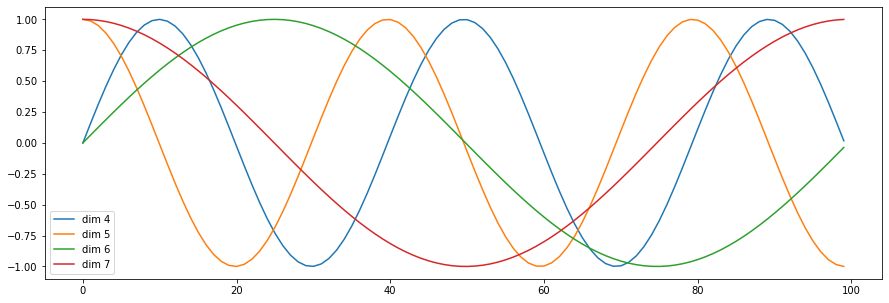

In [ ]:

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 10000.0)
y = pe.forward((torch.zeros(1, 100, 20)))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])

The above plot image should look like this:

[click to see hint](https://cs7150.baulab.info/2022-Fall/colab/position-encoding.png)


### Task 1.4: Implement Transformer Decoder Cell

In [ ]:
from re import X
class TransformerDecoderCell(nn.Module):
    """
    A single cell (unit) of the Transformer decoder.
    """
    def __init__(self, input_dim: int, num_heads: int, ff_dim: int, dropout: float=0.1):
        """
        Inputs:
        - input_dim: Input dimension for each token in a sequence
        - num_heads: Number of attention heads in a multi-head attention module
        - ff_dim: The hidden dimension for a feedforward network
        - dropout: Dropout ratio for the output of the multi-head attention and feedforward
          modules.
        """
        super(TransformerDecoderCell, self).__init__()
        
        ###########################################################################
        # TODO: Similar to the TransformerEncoderCell, define two                 #
        # MultiHeadAttention modules. One for processing the tokens on the        # 
        # decoder side. The other for getting the attention across the encoder.   #
        # and the decoder. Also define a feedforward network. Don't forget the    #
        # Dropout and Layer Norm layers.                                          #
        ###########################################################################
        self.norm = nn.LayerNorm(input_dim)
        self.self_attn1 = MultiHeadAttention(input_dim, num_heads)
        self.self_attn2 = MultiHeadAttention(input_dim, num_heads)

        #self.transformer_block = TransformerEncoderCell(input_dim, num_heads, ff_dim, dropout)
        self.norm1 = nn.LayerNorm(input_dim)
        self.norm2 = nn.LayerNorm(input_dim)
        self.dropout = nn.Dropout(dropout)

        self.linear_net = FeedForwardNetwork(input_dim, ff_dim, dropout)




        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################
        
    def forward(self, x: torch.Tensor, encoder_output: torch.Tensor, src_mask=None, tgt_mask=None):            
        """
        Inputs: 
        - x: Tensor of BxLdxC, word embeddings on the decoder side
        - encoder_output: Tensor of BxLexC, word embeddings on the encoder side
        - src_mask: Tensor, masks of the tokens on the encoder side
        - tgt_mask: Tensor, masks of the tokens on the decoder side
        
        Return:
        - y: Tensor of BxLdxC. Attended features for all tokens on the decoder side.
        """
        
        y = None
        ###########################################################################
        # TODO: Compute the self-attended features for the tokens on the decoder  #
        # side. Then compute the cross-attended features for the tokens on the    #
        # decoder side to the encoded features, which are finally feed into the   #
        # feedforward network                                                     #
        ###########################################################################

# part-1
        attention = self.self_attn1(x, x, x, tgt_mask)       
        x = x + self.dropout(attention)
        X = self.norm1(x)
#part -2
        attention2 = self.self_attn2(x, encoder_output, encoder_output,src_mask)
        y = x + self.dropout(attention2)
        y = self.norm2(y)

        linear_out = self.linear_net(y)
        y  = y + self.dropout(linear_out)
        y = self.norm(y)


      
  




        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################
        
        return y

In [ ]:
dec_feats = torch.randn((3, 10, 16))
dec_mask = torch.randn((3, 1, 10, 10)) > 0.5

enc_feats = torch.randn((3, 12, 16))
enc_mask = torch.randn((3, 1, 1, 12)) > 0.5

model = TransformerDecoderCell(16, 2, 32, 0.1)
z = model(dec_feats, enc_feats, enc_mask, dec_mask)
assert len(z.shape) == len(dec_feats.shape)
for dim_z, dim_x in zip(z.shape, dec_feats.shape):
    assert dim_z == dim_x
print(z.shape)

torch.Size([3, 10, 16])


### Transformer Decoder

In [ ]:
class TransformerDecoder(nn.Module):
    """
    A TransformerDecoder is a stack of multiple TransformerDecoderCells and a Layer Norm.
    """
    def __init__(self, input_dim: int, num_heads: int, ff_dim: int, num_cells: int, dropout=0.1):
        """
        Inputs:
        - input_dim: Input dimension for each token in a sequence
        - num_heads: Number of attention heads in a multi-head attention module
        - ff_dim: The hidden dimension for a feedforward network
        - num_cells: How many TransformerDecoderCells in stack
        - dropout: Dropout ratio for the output of the multi-head attention and feedforward
          modules.
        """
        super(TransformerDecoder, self).__init__()
        
        self.trx_decoder_cell_list = nn.ModuleList(
            [TransformerDecoderCell(input_dim, num_heads, ff_dim, dropout) for _ in range(num_cells)]
        )
        
        self.norm = nn.LayerNorm(input_dim)
    
    def forward(self, x: torch.Tensor, encoder_output: torch.Tensor, src_mask=None, tgt_mask=None):            
        """
        Inputs: 
        - x: Tensor of BxLdxC, word embeddings on the decoder side
        - encoder_output: Tensor of BxLexC, word embeddings on the encoder side
        - src_mask: Tensor, masks of the tokens on the encoder side
        - tgt_mask: Tensor, masks of the tokens on the decoder side
        
        Return:
        - y: Tensor of BxLdxC. Attended features for all tokens on the decoder side.
        """
        
        y = None
        memory = encoder_output
        for trx_cell_i in self.trx_decoder_cell_list:
            x = trx_cell_i(x, memory, src_mask, tgt_mask)
        y = self.norm(x)
        return y

In [ ]:
dec_feats = torch.randn((3, 10, 16))
dec_mask = torch.randn((3, 1, 10, 10)) > 0.5

enc_feats = torch.randn((3, 12, 16))
enc_mask = torch.randn((3, 1, 1, 12)) > 0.5

model = TransformerDecoder(16, 2, 32, 2, 0.1)
z = model(dec_feats, enc_feats, enc_mask, dec_mask)
assert len(z.shape) == len(dec_feats.shape)
for dim_z, dim_x in zip(z.shape, dec_feats.shape):
    assert dim_z == dim_x
print(z.shape)

torch.Size([3, 10, 16])


### Task 1.5: Implement a Transformer-based Sequence-to-sequence model

In [ ]:
class Seq2SeqTransformer(nn.Module):
    """
    Transformer-based sequence-to-sequence model.
    """
    def __init__(self, 
            num_encoder_layers: int, num_decoder_layers: int, embed_dim: int,
            num_heads: int, src_vocab_size: int, tgt_vocab_size: int,
            trx_ff_dim: int = 512, dropout: float = 0.1, pad_token: int=0
        ):
        """
        Inputs:
        - num_encoder_layers: How many TransformerEncoderCell in stack
        - num_decoder_layers: How many TransformerDecoderCell in stack
        - embed_dim: Word embeddings dimension
        - num_heads: Number of attention heads
        - src_vocab_size: Number of tokens in the source language vocabulary
        - tgt_vocab_size: Number of tokens in the target language vocabulary
        - trx_ff_dim: Hidden dimension in the feedforward network
        - dropout: Dropout ratio
        """
        super(Seq2SeqTransformer, self).__init__()
        
        self.embed_dim = embed_dim
        
        # Word embeddings for both the source and target languages
        self.src_token_embed = nn.Embedding(src_vocab_size, embed_dim, padding_idx=pad_token)
        self.tgt_token_embed = nn.Embedding(tgt_vocab_size, embed_dim, padding_idx=pad_token)
        
        ###########################################################################
        # TODO: Define the positional encoding, encoder, decoder, and the output  #
        # layer. Think of how many classes are in the output layer.               #
        ###########################################################################
        self.pos_encoding = PositionalEncoding(embed_dim)
        self.decoder = TransformerDecoder(embed_dim, num_heads, trx_ff_dim, num_decoder_layers, dropout)
        self.encoder = TransformerEncoder(embed_dim, num_heads, trx_ff_dim, num_encoder_layers, dropout)
        self.output_layer = nn.Linear(embed_dim, tgt_vocab_size)





        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################
        
    def forward(self, src: torch.Tensor, tgt: torch.Tensor, src_mask: torch.Tensor, tgt_mask: torch.Tensor):
        """
        Inputs:
        - src: Tensor of BxLe, word indexes in the source language
        - tgt: Tensor of BxLd, word indexes in the target language
        - src_mask: Tensor, masks of the tokens on the encoder side
        - tgt_mask: Tensor, masks of the tokens on the decoder side
        
        Return:
        - y: Tensor of BxLdxK. K is the number of classes in the output.
        """
        
        logits = None

        src_embed = self.encode(src, src_mask)
        tgt_embed = self.decode(tgt, src_embed, src_mask, tgt_mask)
        
        logits = self.output_layer(tgt_embed)
        
        return logits

    def encode(self, src: Tensor, src_mask: Tensor):
      src_embed = self.src_token_embed(src) * math.sqrt(self.embed_dim)
      return self.encoder(self.pos_encoding(src_embed), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, src_mask: Tensor, tgt_mask: Tensor):
      tgt_embed = self.tgt_token_embed(tgt) * math.sqrt(self.embed_dim)
      return self.decoder(self.pos_encoding(tgt_embed), memory, src_mask, tgt_mask)
        

In [ ]:
src_vocab_size = 10
src = torch.arange(src_vocab_size).view(1, -1)
src = torch.cat((src, src), dim=0)
src_mask = torch.randn((2, 1, 1, src_vocab_size)) > 0.5

tgt_vocab_size = 12
tgt = torch.arange(tgt_vocab_size).view(1, -1)
tgt = torch.cat((tgt, tgt), dim=0)
tgt_mask = torch.randn((2, 1, tgt_vocab_size, tgt_vocab_size)) > 0.5

model = Seq2SeqTransformer(2, 2, 16, 2, src_vocab_size, tgt_vocab_size, 32, 0.1, 0)
z = model(src, tgt, src_mask, tgt_mask)
print(z.shape)

torch.Size([2, 12, 12])


### Create Attention Masks

In [ ]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0


def create_mask(src, tgt, pad_token=0):
    src_mask = (src != pad_token).unsqueeze(-2).unsqueeze(1)
    
    tgt_seq_len = tgt.shape[0]
    tgt_mask = (tgt != pad_token).unsqueeze(-2)
    tgt_mask = tgt_mask & subsequent_mask(tgt.shape[1]).type_as(tgt_mask.data)

    return src_mask, tgt_mask.unsqueeze(1)

torch.Size([2, 1, 1, 10]) torch.Size([2, 1, 10, 10])


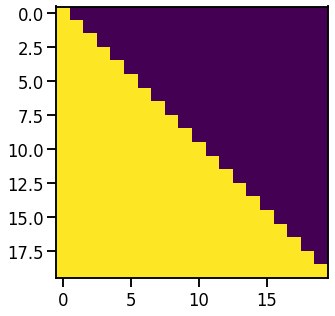

In [ ]:
# Let's visualize what the target mask looks like
import matplotlib.pyplot as plt

import seaborn
seaborn.set_context(context="talk")

plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(20)[0].numpy())

x = torch.arange(src_vocab_size).view(1, -1)
x = torch.cat((x, x), dim=0)
src_mask, tgt_mask = create_mask(x, x)
print(src_mask.shape, tgt_mask.shape)

### Prepare Data Loaders

In [ ]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import Multi30k
from typing import Iterable, List


SRC_LANGUAGE = 'de'
TGT_LANGUAGE = 'en'

# Place-holders
token_transform = {}
vocab_transform = {}


# # Create source and target language tokenizer. Make sure to install the dependencies.

token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='de_core_news_sm')
token_transform[TGT_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')


# helper function to yield list of tokens
def yield_tokens(data_iter: Iterable, language: str) -> List[str]:
    language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}

    for data_sample in data_iter:
        yield token_transform[language](data_sample[language_index[language]])

# Define special symbols and indices
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']
 
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    # Training data Iterator 
    train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    # Create torchtext's Vocab object 
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train_iter, ln),
                                                    min_freq=1,
                                                    specials=special_symbols,
                                                    special_first=True)

# Set UNK_IDX as the default index. This index is returned when the token is not found. 
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary. 
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)

In [ ]:
from torch.nn.utils.rnn import pad_sequence

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([BOS_IDX]), 
                      torch.tensor(token_ids), 
                      torch.tensor([EOS_IDX])))

# src and tgt language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[ln] = sequential_transforms(
        token_transform[ln], #Tokenization
        vocab_transform[ln], #Numericalization
        tensor_transform # Add BOS/EOS and create tensor
    )


# function to collate data samples into batch tesors
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch.transpose(0, 1), tgt_batch.transpose(0, 1)

In [ ]:
BATCH_SIZE = 8

train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

val_iter = Multi30k(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
val_dataloader = DataLoader(val_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

for idx, (src, tgt) in enumerate(train_dataloader):
    if idx > 2:
        break
    print('src: {}, tgt: {}'.format(src.shape, tgt.shape))

src: torch.Size([8, 18]), tgt: torch.Size([8, 17])
src: torch.Size([8, 20]), tgt: torch.Size([8, 19])
src: torch.Size([8, 18]), tgt: torch.Size([8, 19])


### Task 1.6: Define the Model and Loss Function

In [ ]:
torch.manual_seed(0)

SRC_VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE])
TGT_VOCAB_SIZE = len(vocab_transform[TGT_LANGUAGE])
EMBED_SIZE = 512
NUM_ATTN_HEADS = 8
FF_DIM = 512
BATCH_SIZE = 128
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3

###########################################################################
# TODO: Define the model and loss function.                               #
# Note that this time we will generate tokens, where some of them in the  #
# training time are from paddings. We don't want to penalize the model    #
# if the output at such positions are wrong. You can use the              #
# `ignore_index` in a loss function to suppress loss computation if the   #
# ground-truth label is equal to the given value. Check here for          #
# more details https://pytorch.org/docs/stable/nn.html#loss-functions     #
###########################################################################
transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMBED_SIZE, 
                                 NUM_ATTN_HEADS, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FF_DIM)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)
###########################################################################
#                             END OF YOUR CODE                            #
###########################################################################

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)
transformer = transformer.to(device)

optimizer = torch.optim.Adam(
    transformer.parameters(), 
    lr=0.0001, 
    betas=(0.9, 0.98), 
    eps=1e-9
)

### Model Training and Validation

In [ ]:
def train_epoch(model, optimizer):
    model.train()
    losses = 0
    
    train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)
    train_item_counter = 0
    for src, tgt in train_dataloader:
        src = src.to(device)
        tgt = tgt.to(device)

        tgt_input = tgt[:, :-1]

        src_mask, tgt_mask = create_mask(src, tgt_input)
        src_mask = src_mask.to(device)
        tgt_mask = tgt_mask.to(device)

        logits = model(src, tgt_input, src_mask, tgt_mask)

        optimizer.zero_grad()

        tgt_out = tgt[:, 1:]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        optimizer.step()
        losses += loss.item()
        train_item_counter += 1

    return losses / train_item_counter


def evaluate(model):
    model.eval()
    losses = 0

    val_iter = Multi30k(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    val_dataloader = DataLoader(val_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)
    val_item_counter = 0
    for src, tgt in val_dataloader:
        src = src.to(device)
        tgt = tgt.to(device)

        tgt_input = tgt[:, :-1]

        src_mask, tgt_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask)
        
        tgt_out = tgt[:, 1:]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()
        val_item_counter += 1

    return losses / val_item_counter

from timeit import default_timer as timer
NUM_EPOCHS = 10

# You should be able to get train loss around 1.5 and val loss around 2.2
for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer)
    end_time = timer()
    val_loss = evaluate(transformer)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))

Epoch: 1, Train loss: 5.375, Val loss: 4.146, Epoch time = 36.543s
Epoch: 2, Train loss: 3.738, Val loss: 3.359, Epoch time = 38.071s
Epoch: 3, Train loss: 3.092, Val loss: 2.929, Epoch time = 37.726s
Epoch: 4, Train loss: 2.655, Val loss: 2.658, Epoch time = 37.531s
Epoch: 5, Train loss: 2.328, Val loss: 2.483, Epoch time = 37.560s
Epoch: 6, Train loss: 2.060, Val loss: 2.358, Epoch time = 37.539s
Epoch: 7, Train loss: 1.843, Val loss: 2.263, Epoch time = 37.969s
Epoch: 8, Train loss: 1.656, Val loss: 2.198, Epoch time = 37.586s
Epoch: 9, Train loss: 1.498, Val loss: 2.177, Epoch time = 37.546s
Epoch: 10, Train loss: 1.363, Val loss: 2.139, Epoch time = 37.600s


In [ ]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=device)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

# function to generate output sequence using greedy algorithm
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(device)
    src_mask = src_mask.to(device)
    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(device)
    for i in range(max_len-1):
        memory = memory.to(device)
        tgt_mask = (subsequent_mask(ys.size(1))
                    .type(torch.bool)).to(device)
        cross_mask = torch.ones(1,i + 1,src.size(1), device=device)
        out = model.decode(ys, memory, cross_mask, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.output_layer(out[:, -1])
        _, next_word = torch.max(prob[-1,:], dim=0)
        next_word = next_word.item()
        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
        if next_word == EOS_IDX:
            break
    return ys


# actual function to translate input sentence into target language
def translate(model: torch.nn.Module, src_sentence: str):
    model.eval()
    src = text_transform[SRC_LANGUAGE](src_sentence).view(1, -1)
    num_tokens = src.shape[1]
    src_mask = (torch.zeros(1, num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
    return " ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<bos>", "").replace("<eos>", "")

In [ ]:
print(translate(transformer, "Eine Gruppe von Menschen steht vor einem Iglu ."))

 A group of people standing in front of a mountain . 
